<a href="https://colab.research.google.com/github/Nilanjan-Chatterjee/Aahar/blob/main/Yolo_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Preparing dataset**

In [ ]:
#import all the libraries
import os
import torch
import glob
from torch.utils.data import Dataset
import time
import copy
import numpy as np
import math
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
from torch.utils.data.dataset import Dataset  # For custom data-sets
import torchvision.transforms as transforms
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
import argparse
import logging
import sys
import cv2
import torch.nn as nn
from torch import optim
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split
from collections import OrderedDict


In [ ]:
#connecting the drive to colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Creating dataset
class ListDataset(Dataset):
    def __init__(self, img_path,label_path, img_size=416):
        
        #super(DataLoaderSegmentation, self).__init__()
        image_class=os.listdir(img_path)
        self.img_files=[]
        for cls in image_class:
            self.img_files += glob.glob(img_path+cls+'/'+'*.bmp')
       
        self.label_files = []
        self.inputs_dtype = torch.float32
        self.targets_dtype = torch.long

        
        for img_path1 in self.img_files:
          
          self.label_files.append(label_path+cls+'neucleus'+img_path1[-7:-4]+'.txt')
        self.img_shape = (img_size, img_size)
        self.max_objects = 200
        print(len(self.img_files),"         ",len(self.label_files))

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, index):

        #---------
        #  Image
        #---------

        img_path = self.img_files[index % len(self.img_files)].rstrip()
        img = cv2.imread(img_path)
        h, w, _ = img.shape
        dim_diff = np.abs(h - w)
        # Upper (left) and lower (right) padding
        pad1, pad2 = dim_diff // 2, dim_diff - dim_diff // 2
        # Determine padding
        pad = ((pad1, pad2), (0, 0), (0, 0)) if h <= w else ((0, 0), (pad1, pad2), (0, 0))
        # Add padding
        pad_img = np.pad(img, pad, 'constant', constant_values=128)

        padded_h, padded_w, _ = pad_img.shape

        # Resize
        pad_img = cv2.resize(pad_img, self.img_shape)
        # Channels-first
        input_img = pad_img[:, :, ::-1].transpose((2, 0, 1)).copy()
        # As pytorch tensor
        input_img = torch.from_numpy(input_img).float().div(255.0)

        #---------
        #  Label
        #---------

        label_path = self.label_files[index % len(self.img_files)].rstrip()

        labels = None
        if os.path.exists(label_path):
            labels = np.loadtxt(label_path).reshape(-1, 5)
           
            # Extract coordinates for unpadded + unscaled image
            x1 = w * (labels[:, 1] - labels[:, 3]/2)
            y1 = h * (labels[:, 2] - labels[:, 4]/2)
            x2 = w * (labels[:, 1] + labels[:, 3]/2)
            y2 = h * (labels[:, 2] + labels[:, 4]/2)
            # Adjust for added padding
            x1 += pad[1][0]
            y1 += pad[0][0]
            x2 += pad[1][0]
            y2 += pad[0][0]
            # Calculate ratios from coordinates
            labels[:, 1] = ((x1 + x2) / 2) / padded_w
            labels[:, 2] = ((y1 + y2) / 2) / padded_h
            labels[:, 3] *= w / padded_w
            labels[:, 4] *= h / padded_h
        # Fill matrix
        filled_labels = np.zeros((self.max_objects, 5))
        if labels is not None:
            filled_labels[range(len(labels))[:self.max_objects]] = labels[:self.max_objects]
        filled_labels = torch.from_numpy(filled_labels)
        
        sample = {'input_img': input_img, 'orig_img': pad_img, 'label': filled_labels, 'path': img_path}

        return sample

In [ ]:
#creating dataloader
batch_size = 1
inp_dim = 416
input_path='/content/gdrive/MyDrive/Sipakmed/'
ouput_path='/content/gdrive/MyDrive/sipakmed_result2/'
dataloaders = {'train': torch.utils.data.DataLoader(ListDataset(input_path,ouput_path, img_size=inp_dim), batch_size=batch_size, shuffle=True,num_workers=1),
               'val': torch.utils.data.DataLoader(ListDataset(input_path,ouput_path, img_size=inp_dim), batch_size=batch_size, shuffle=True,num_workers=1)}
print(len(dataloaders['train']))
"""for i_batch, sample_batched in enumerate(dataloaders["train"]):
    input_images_batch, Orig_images_batch, label_batch, path_batch = sample_batched['input_img'], sample_batched['orig_img'], sample_batched['label'], sample_batched['path']
    print('nare',i_batch, input_images_batch.shape, Orig_images_batch.shape, label_batch.shape)
    
    if i_batch == 10000:
        break"""

966           966
966           966
966


'for i_batch, sample_batched in enumerate(dataloaders["train"]):\n    input_images_batch, Orig_images_batch, label_batch, path_batch = sample_batched[\'input_img\'], sample_batched[\'orig_img\'], sample_batched[\'label\'], sample_batched[\'path\']\n    print(\'nare\',i_batch, input_images_batch.shape, Orig_images_batch.shape, label_batch.shape)\n    \n    if i_batch == 10000:\n        break'

In [ ]:
#building targets
def build_targets(target, anchors, grid_size, num_anchors = 3, num_classes = 1):

    nB = target.size(0)
    nA = num_anchors
    nC = num_classes
    nG = grid_size
    mask = torch.zeros(nB, nA, nG, nG)
    tx = torch.zeros(nB, nA, nG, nG)
    ty = torch.zeros(nB, nA, nG, nG)
    tw = torch.zeros(nB, nA, nG, nG)
    th = torch.zeros(nB, nA, nG, nG)
    tconf = torch.zeros(nB, nA, nG, nG)
    tcls = torch.zeros(nB, nA, nG, nG, nC)

    for b in range(nB):  # for each image
        for t in range(target.shape[1]):  # for each object
            if target[b, t].sum() == 0:  # if the row is empty
                continue
            # Convert to object label data to feature map
            gx = target[b, t, 1] * nG
            gy = target[b, t, 2] * nG
            gw = target[b, t, 3] * nG
            gh = target[b, t, 4] * nG
            # Get grid box indices
            gi = int(gx)
            gj = int(gy)
            # Get shape of gt box
            gt_box = torch.FloatTensor(np.array([0, 0, gw, gh])).unsqueeze(0)  # 1 x 4
            # Get shape of anchor box
            anchor_shapes = torch.FloatTensor(
                np.concatenate((np.zeros((len(anchors), 2)), np.array(anchors)), 1))
            # Calculate iou between gt and anchor shapes
            anch_ious = bbox_iou(gt_box, anchor_shapes)
            # Find the best matching anchor box
            best_n = np.argmax(anch_ious)
            # Masks
            mask[b, best_n, gj, gi] = 1
            # Coordinates
            tx[b, best_n, gj, gi] = gx - gi
            ty[b, best_n, gj, gi] = gy - gj
            # Width and height
            tw[b, best_n, gj, gi] = math.log(gw / anchors[best_n][0] + 1e-16)
            th[b, best_n, gj, gi] = math.log(gh / anchors[best_n][1] + 1e-16)
            # One-hot encoding of label
            target_label = int(target[b, t, 0])
            tcls[b, best_n, gj, gi, target_label] = 1
            tconf[b, best_n, gj, gi] = 1

    return mask, tx, ty, tw, th, tconf, tcls

#calculating loss
def Loss(input, target, anchors, inp_dim, num_anchors = 3, num_classes = 1):

    nA = num_anchors  # number of anchors
    nB = input.size(0)  # number of batches
    nG = input.size(2)  # number of grid size
    nC = num_classes
    stride = inp_dim / nG

    # Tensors for cuda support
    FloatTensor = torch.cuda.FloatTensor if input.is_cuda else torch.FloatTensor
    ByteTensor = torch.cuda.ByteTensor if input.is_cuda else torch.ByteTensor

    prediction = input.view(nB, nA, 5 + nC, nG, nG).permute(0, 1, 3, 4, 2).contiguous()  # reshape the output data

    # Get outputs
    x = torch.sigmoid(prediction[..., 0])  # Center x
    y = torch.sigmoid(prediction[..., 1])  # Center y
    w = prediction[..., 2]  # Width
    h = prediction[..., 3]  # Height
    pred_conf = torch.sigmoid(prediction[..., 4])  # Conf
    pred_cls = torch.sigmoid(prediction[..., 5:])  # Cls pred

    # Calculate offsets for each grid
    grid_x = torch.arange(nG).repeat(nG, 1).view([1, 1, nG, nG]).type(FloatTensor)
    grid_y = torch.arange(nG).repeat(nG, 1).t().view([1, 1, nG, nG]).type(FloatTensor)
    scaled_anchors = FloatTensor([(a_w / stride, a_h / stride) for a_w, a_h in anchors])
    anchor_w = scaled_anchors[:, 0:1].view((1, nA, 1, 1))
    anchor_h = scaled_anchors[:, 1:2].view((1, nA, 1, 1))

    # Add offset and scale with anchors
    pred_boxes = FloatTensor(prediction[..., :4].shape)
    pred_boxes[..., 0] = x.data + grid_x
    pred_boxes[..., 1] = y.data + grid_y
    pred_boxes[..., 2] = torch.exp(w.data) * anchor_w
    pred_boxes[..., 3] = torch.exp(h.data) * anchor_h

    mask, tx, ty, tw, th, tconf, tcls = build_targets(
        target=target.cpu().data,
        anchors=scaled_anchors.cpu().data,
        grid_size=nG,
        num_anchors=nA,
        num_classes=num_classes)

    # Handle target variables
    tx, ty = tx.type(FloatTensor), ty.type(FloatTensor)
    tw, th = tw.type(FloatTensor), th.type(FloatTensor)
    tconf, tcls = tconf.type(FloatTensor), tcls.type(FloatTensor)
    mask = mask.type(ByteTensor)

    mse_loss = nn.MSELoss(reduction='sum')  # Coordinate loss
    bce_loss = nn.BCELoss(reduction='sum')  # Confidence loss
    loss_x = mse_loss(x[mask], tx[mask])
    loss_y = mse_loss(y[mask], ty[mask])
    loss_w = mse_loss(w[mask], tw[mask])
    loss_h = mse_loss(h[mask], th[mask])
    loss_conf = bce_loss(pred_conf, tconf)
    loss_cls = bce_loss(pred_cls[mask], tcls[mask])
    loss = loss_x + loss_y + loss_w + loss_h + loss_conf + loss_cls

    return (loss, loss_x, loss_y, loss_w, loss_h, loss_conf, loss_cls)

**Creating model**

In [ ]:
#defining model
class EmptyLayer(nn.Module):
    def __init__(self):
        super(EmptyLayer, self).__init__()

class Darknet(nn.Module):

    def __init__(self):
        super(Darknet, self).__init__()
        self.image_size = 416
        self.module_list = nn.ModuleList()
        self.blocks = []

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_0", nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)),
                    ("batch_norm_0", nn.BatchNorm2d(32)),
                    ("leaky_0", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type':'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_1", nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)),
                    ("batch_norm_1", nn.BatchNorm2d(64)),
                    ("leaky_1", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_2", nn.Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)),
                    ("batch_norm_2", nn.BatchNorm2d(32)),
                    ("leaky_2", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_3", nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_3", nn.BatchNorm2d(64)),
                    ("leaky_3", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("shortcut_4", EmptyLayer()),
                    ])))
        self.blocks.append({'type': 'shortcut', 'from': '-3'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_5", nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1),bias=False)),
                    ("batch_norm_5", nn.BatchNorm2d(128)),
                    ("leaky_5", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_6", nn.Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_6", nn.BatchNorm2d(64)),
                    ("leaky_6", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_7", nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_7", nn.BatchNorm2d(128)),
                    ("leaky_7", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("shortcut_8", EmptyLayer()),
                    ])))
        self.blocks.append({'type': 'shortcut', 'from': '-3'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_9", nn.Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_9", nn.BatchNorm2d(64)),
                    ("leaky_9", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_10", nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_10", nn.BatchNorm2d(128)),
                    ("leaky_10", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("shortcut_11", EmptyLayer()),
                    ])))
        self.blocks.append({'type': 'shortcut', 'from': '-3'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_12", nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1),bias=False)),
                    ("batch_norm_12", nn.BatchNorm2d(256)),
                    ("leaky_12", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_13", nn.Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_13", nn.BatchNorm2d(128)),
                    ("leaky_13", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_14", nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_14", nn.BatchNorm2d(256)),
                    ("leaky_14", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("shortcut_15", EmptyLayer()),
                    ])))
        self.blocks.append({'type': 'shortcut', 'from': '-3'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_16", nn.Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_16", nn.BatchNorm2d(128)),
                    ("leaky_16", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_17", nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_17", nn.BatchNorm2d(256)),
                    ("leaky_17", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("shortcut_18", EmptyLayer()),
                    ])))
        self.blocks.append({'type': 'shortcut', 'from': '-3'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_19", nn.Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_19", nn.BatchNorm2d(128)),
                    ("leaky_19", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_20", nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_20", nn.BatchNorm2d(256)),
                    ("leaky_20", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("shortcut_21", EmptyLayer()),
                    ])))
        self.blocks.append({'type': 'shortcut', 'from': '-3'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_22", nn.Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_22", nn.BatchNorm2d(128)),
                    ("leaky_22", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_23", nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_23", nn.BatchNorm2d(256)),
                    ("leaky_23", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("shortcut_24", EmptyLayer()),
                    ])))
        self.blocks.append({'type': 'shortcut', 'from': '-3'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_25", nn.Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_25", nn.BatchNorm2d(128)),
                    ("leaky_25", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_26", nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_26", nn.BatchNorm2d(256)),
                    ("leaky_26", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("shortcut_27", EmptyLayer()),
                    ])))
        self.blocks.append({'type': 'shortcut', 'from': '-3'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_28", nn.Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_28", nn.BatchNorm2d(128)),
                    ("leaky_28", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_29", nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_29", nn.BatchNorm2d(256)),
                    ("leaky_29", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("shortcut_30", EmptyLayer()),
                    ])))
        self.blocks.append({'type': 'shortcut', 'from': '-3'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_31", nn.Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_31", nn.BatchNorm2d(128)),
                    ("leaky_31", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_32", nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_32", nn.BatchNorm2d(256)),
                    ("leaky_32", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("shortcut_33", EmptyLayer()),
                    ])))
        self.blocks.append({'type': 'shortcut', 'from': '-3'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_34", nn.Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_34", nn.BatchNorm2d(128)),
                    ("leaky_34", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_35", nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_35", nn.BatchNorm2d(256)),
                    ("leaky_35", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("shortcut_36", EmptyLayer()),
                    ])))
        self.blocks.append({'type': 'shortcut', 'from': '-3'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_37", nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1),bias=False)),
                    ("batch_norm_37", nn.BatchNorm2d(512)),
                    ("leaky_37", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_38", nn.Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_38", nn.BatchNorm2d(256)),
                    ("leaky_38", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_39", nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_39", nn.BatchNorm2d(512)),
                    ("leaky_39", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("shortcut_40", EmptyLayer()),
                    ])))
        self.blocks.append({'type': 'shortcut', 'from': '-3'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_41", nn.Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_41", nn.BatchNorm2d(256)),
                    ("leaky_41", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_42", nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_42", nn.BatchNorm2d(512)),
                    ("leaky_42", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("shortcut_43", EmptyLayer()),
                    ])))
        self.blocks.append({'type': 'shortcut', 'from': '-3'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_44", nn.Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_44", nn.BatchNorm2d(256)),
                    ("leaky_44", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_45", nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_45", nn.BatchNorm2d(512)),
                    ("leaky_45", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("shortcut_46", EmptyLayer()),
                    ])))
        self.blocks.append({'type': 'shortcut', 'from': '-3'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_47", nn.Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_47", nn.BatchNorm2d(256)),
                    ("leaky_47", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_48", nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_48", nn.BatchNorm2d(512)),
                    ("leaky_48", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("shortcut_49", EmptyLayer()),
                    ])))
        self.blocks.append({'type': 'shortcut', 'from': '-3'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_50", nn.Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_50", nn.BatchNorm2d(256)),
                    ("leaky_50", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_51", nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_51", nn.BatchNorm2d(512)),
                    ("leaky_51", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("shortcut_52", EmptyLayer()),
                    ])))
        self.blocks.append({'type': 'shortcut', 'from': '-3'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_53", nn.Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_53", nn.BatchNorm2d(256)),
                    ("leaky_53", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_54", nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_54", nn.BatchNorm2d(512)),
                    ("leaky_54", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("shortcut_55", EmptyLayer()),
                    ])))
        self.blocks.append({'type': 'shortcut', 'from': '-3'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_56", nn.Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_56", nn.BatchNorm2d(256)),
                    ("leaky_56", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_57", nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_57", nn.BatchNorm2d(512)),
                    ("leaky_57", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("shortcut_58", EmptyLayer()),
                    ])))
        self.blocks.append({'type': 'shortcut', 'from': '-3'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_59", nn.Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_59", nn.BatchNorm2d(256)),
                    ("leaky_59", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_60", nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_60", nn.BatchNorm2d(512)),
                    ("leaky_60", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("shortcut_61", EmptyLayer()),
                    ])))
        self.blocks.append({'type': 'shortcut', 'from': '-3'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_62", nn.Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1),bias=False)),
                    ("batch_norm_62", nn.BatchNorm2d(1024)),
                    ("leaky_62", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_63", nn.Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_63", nn.BatchNorm2d(512)),
                    ("leaky_63", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_64", nn.Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_64", nn.BatchNorm2d(1024)),
                    ("leaky_64", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("shortcut_65", EmptyLayer()),
                    ])))
        self.blocks.append({'type': 'shortcut', 'from': '-3'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_66", nn.Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_66", nn.BatchNorm2d(512)),
                    ("leaky_66", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_67", nn.Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_67", nn.BatchNorm2d(1024)),
                    ("leaky_67", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("shortcut_68", EmptyLayer()),
                    ])))
        self.blocks.append({'type': 'shortcut', 'from': '-3'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_69", nn.Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_69", nn.BatchNorm2d(512)),
                    ("leaky_69", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_70", nn.Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_70", nn.BatchNorm2d(1024)),
                    ("leaky_70", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("shortcut_71", EmptyLayer()),
                    ])))
        self.blocks.append({'type': 'shortcut', 'from': '-3'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_72", nn.Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_72", nn.BatchNorm2d(512)),
                    ("leaky_72", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_73", nn.Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_73", nn.BatchNorm2d(1024)),
                    ("leaky_73", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("shortcut_74", EmptyLayer()),
                    ])))
        self.blocks.append({'type': 'shortcut', 'from': '-3'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_75", nn.Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_75", nn.BatchNorm2d(512)),
                    ("leaky_75", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_76", nn.Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_76", nn.BatchNorm2d(1024)),
                    ("leaky_76", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_77", nn.Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_77", nn.BatchNorm2d(512)),
                    ("leaky_77", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_78", nn.Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_78", nn.BatchNorm2d(1024)),
                    ("leaky_78", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_79", nn.Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_79", nn.BatchNorm2d(512)),
                    ("leaky_79", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_80", nn.Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_80", nn.BatchNorm2d(1024)),
                    ("leaky_80", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_81", nn.Conv2d(1024, 18, kernel_size=(1, 1), stride=(1, 1)))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("Dectection_82", EmptyLayer()),
                    ])))
        self.blocks.append({'type': 'yolo', 'anchors': '116,90,  156,198,  373,326'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("route_83", EmptyLayer()),
                    ])))
        self.blocks.append({'type': 'route', 'layers': '-4'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_84", nn.Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_84", nn.BatchNorm2d(256)),
                    ("leaky_84", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("upsample_85", nn.Upsample(scale_factor=2, mode='nearest')),
                    ])))
        self.blocks.append({'type': 'upsample'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("route_86", EmptyLayer()),
                    ])))
        self.blocks.append({'type': 'route', 'layers': '-1, 61'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_87", nn.Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_87", nn.BatchNorm2d(256)),
                    ("leaky_87", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_88", nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_88", nn.BatchNorm2d(512)),
                    ("leaky_88", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_89", nn.Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_89", nn.BatchNorm2d(256)),
                    ("leaky_89", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_90", nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_90", nn.BatchNorm2d(512)),
                    ("leaky_90", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_91", nn.Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_91", nn.BatchNorm2d(256)),
                    ("leaky_91", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_92", nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_92", nn.BatchNorm2d(512)),
                    ("leaky_92", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_93", nn.Conv2d(512, 18, kernel_size=(1, 1), stride=(1, 1)))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("Dectection_94", EmptyLayer()),
                    ])))
        self.blocks.append({'type': 'yolo', 'anchors': '30,61,  62,45,  59,119'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("route_95", EmptyLayer()),
                    ])))
        self.blocks.append({'type': 'route', 'layers': '-4'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_96", nn.Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_96", nn.BatchNorm2d(128)),
                    ("leaky_96", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("upsample_97", nn.Upsample(scale_factor=2, mode='nearest')),
                    ])))
        self.blocks.append({'type': 'upsample'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("route_98", EmptyLayer()),
                    ])))
        self.blocks.append({'type': 'route', 'layers': '-1, 36'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_99", nn.Conv2d(384, 128, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_99", nn.BatchNorm2d(128)),
                    ("leaky_99", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_100", nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_100", nn.BatchNorm2d(256)),
                    ("leaky_100", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_101", nn.Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_101", nn.BatchNorm2d(128)),
                    ("leaky_101", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_102", nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_102", nn.BatchNorm2d(256)),
                    ("leaky_102", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_103", nn.Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1),bias=False)),
                    ("batch_norm_103", nn.BatchNorm2d(128)),
                    ("leaky_103", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_104", nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),bias=False)),
                    ("batch_norm_104", nn.BatchNorm2d(256)),
                    ("leaky_104", nn.LeakyReLU(negative_slope=0.1, inplace=True))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("conv_105", nn.Conv2d(256, 18, kernel_size=(1, 1), stride=(1, 1)))
                    ])))
        self.blocks.append({'type': 'convolutional'})

        self.module_list.append(nn.Sequential(OrderedDict([
                    ("Dectection_106", EmptyLayer()),
                    ])))
        self.blocks.append({'type': 'yolo', 'anchors': '10,13,  16,30,  33,23'})


    def forward(self, x, CUDA):

        modules = self.blocks
        outputs = {}  # cache the outputs for the route layer

        write = 0
        for i, module in enumerate(modules):
            module_type = (module["type"])

            if module_type == "convolutional" or module_type == "upsample":
                x = self.module_list[i](x)

            elif module_type == "route":
                layers = module["layers"].split(",")
                layers = [int(a) for a in layers]

                if (layers[0]) > 0:
                    layers[0] = layers[0] - i

                if len(layers) == 1:
                    x = outputs[i + (layers[0])]

                else:
                    if (layers[1]) > 0:
                        layers[1] = layers[1] - i

                    map1 = outputs[i + layers[0]]
                    map2 = outputs[i + layers[1]]
                    x = torch.cat((map1, map2), 1)

            elif module_type == "shortcut":
                from_ = int(module["from"])
                x = outputs[i - 1] + outputs[i + from_]

            elif module_type == 'yolo':

                anchors = module["anchors"].split(",")
                anchors = [int(a) for a in anchors]
                anchors = [(anchors[i], anchors[i + 1]) for i in range(0, len(anchors), 2)]
                # Get the input dimensions
                inp_dim = int(self.image_size)
                # Get the number of classes
                num_classes = 1

                # Transform
                x = x.data
                
                x = predict_transform(x, inp_dim, anchors, num_classes, CUDA)
                if not write:  # if no collector has been intialised.
                    detections = x
                    write = 1

                else:
                    detections = torch.cat((detections, x), 1)

            outputs[i] = x

        return detections, outputs[105], outputs[93], outputs[81]



In [ ]:
#creating model
model=Darknet()
model

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch

In [ ]:
from __future__ import division

import torch 
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable
import numpy as np
import cv2

def eval(output, labels, img_width, img_height):

    nProposals = int((output[:, 5] > 0.5).sum().item())
    nGT = 0
    nCorrect = 0
    for b in range(labels.shape[0]):  # for each image
        prediction = output[output[:,0] == b]  # filter out the predictions of corresponding image
        for t in range(labels.shape[1]):  # for each object
            if labels[b, t].sum() == 0:  # if the row is empty
                continue
            nGT += 1
            gt_label = convert_label(labels[b, t].unsqueeze(0), img_width, img_height)
            gt_box = gt_label[:, 1:5]
            for i in range(prediction.shape[0]):
                pred_box = prediction[i, 1:5].unsqueeze(0)
                iou = bbox_iou(pred_box, gt_box)
                pred_label = prediction[i, -1]
                target_label = gt_label[0, 0]
                if iou > 0.5 and pred_label == target_label:
                    nCorrect += 1
    recall = float(nCorrect / nGT) if nGT else 1
    precision = float(nCorrect / nProposals) if nProposals else 0
    F1_score = 2 * recall * precision / (recall + precision + 1e-16)

    return F1_score, precision, recall

def convert_label(image_anno, img_width, img_height):

    """
    Function: convert image annotation : center x, center y, w, h (normalized) to x1, y1, x2, y2 for corresponding img
    """
    x_center = image_anno[:, 1]
    y_center = image_anno[:, 2]
    width = image_anno[:, 3]
    height = image_anno[:, 4]

    output = torch.zeros_like(image_anno)
    output[:,0] = image_anno[:,0]
    output[:, 1], output[:, 3] = x_center - width / 2, x_center + width / 2
    output[:, 2], output[:, 4] = y_center - height / 2, y_center + height / 2

    output[:, [1, 3]] *= img_width
    output[:, [2, 4]] *= img_height

    return output.type(torch.FloatTensor)

def unique(tensor):
    tensor_np = tensor.cpu().numpy()
    unique_np = np.unique(tensor_np)
    unique_tensor = torch.from_numpy(unique_np)

    tensor_res = tensor.new(unique_tensor.shape)
    tensor_res.copy_(unique_tensor)
    return tensor_res

def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes
    Two scenarios： 1. box is represented by center and width 2. box is represented by cooridnates of left up and right bottom
    """
    if not x1y1x2y2:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(
        inter_rect_y2 - inter_rect_y1 + 1, min=0
    )
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou

def predict_transform(prediction, inp_dim, anchors, num_classes, CUDA = True):
    
    
    batch_size = prediction.size(0)
    stride =  inp_dim // prediction.size(2)
    grid_size = inp_dim // stride
    bbox_attrs = 5 + num_classes
    num_anchors = len(anchors)
    prediction = prediction.view(batch_size, bbox_attrs*num_anchors, grid_size*grid_size)
    prediction = prediction.transpose(1,2).contiguous()
    prediction = prediction.view(batch_size, grid_size*grid_size*num_anchors, bbox_attrs)
    anchors = [(a[0]/stride, a[1]/stride) for a in anchors]

    #Sigmoid the  centre_X, centre_Y. and object confidencce
    prediction[:,:,0] = torch.sigmoid(prediction[:,:,0])
    prediction[:,:,1] = torch.sigmoid(prediction[:,:,1])
    prediction[:,:,4] = torch.sigmoid(prediction[:,:,4])
    
    #Add the center offsets
    grid = np.arange(grid_size)
    a,b = np.meshgrid(grid, grid)

    x_offset = torch.FloatTensor(a).view(-1,1)
    y_offset = torch.FloatTensor(b).view(-1,1)

    if CUDA:
        x_offset = x_offset.cuda()
        y_offset = y_offset.cuda()

    x_y_offset = torch.cat((x_offset, y_offset), 1).repeat(1,num_anchors).view(-1,2).unsqueeze(0)

    prediction[:,:,:2] += x_y_offset

    #log space transform height and the width
    anchors = torch.FloatTensor(anchors)

    if CUDA:
        anchors = anchors.cuda()

    anchors = anchors.repeat(grid_size*grid_size, 1).unsqueeze(0)
    prediction[:,:,2:4] = torch.exp(prediction[:,:,2:4])*anchors
    
    prediction[:,:,5: 5 + num_classes] = torch.sigmoid((prediction[:,:, 5 : 5 + num_classes]))

    prediction[:,:,:4] *= stride
    
    return prediction

def write_results(prediction, confidence, num_classes, nms_conf = 0.4):
    conf_mask = (prediction[:,:,4] > confidence).float().unsqueeze(2)
    prediction = prediction*conf_mask
    
    box_corner = prediction.new(prediction.shape)
    box_corner[:,:,0] = (prediction[:,:,0] - prediction[:,:,2]/2)
    box_corner[:,:,1] = (prediction[:,:,1] - prediction[:,:,3]/2)
    box_corner[:,:,2] = (prediction[:,:,0] + prediction[:,:,2]/2) 
    box_corner[:,:,3] = (prediction[:,:,1] + prediction[:,:,3]/2)
    prediction[:,:,:4] = box_corner[:,:,:4]
    
    batch_size = prediction.size(0)

    write = False

    for ind in range(batch_size):
        image_pred = prediction[ind]          #image Tensor
       #confidence threshholding 
       #NMS
    
        max_conf, max_conf_score = torch.max(image_pred[:,5:5+ num_classes], 1)
        max_conf = max_conf.float().unsqueeze(1)
        max_conf_score = max_conf_score.float().unsqueeze(1)
        seq = (image_pred[:,:5], max_conf, max_conf_score)
        image_pred = torch.cat(seq, 1)
        
        non_zero_ind =  (torch.nonzero(image_pred[:,4]))
        try:
            image_pred_ = image_pred[non_zero_ind.squeeze(),:].view(-1,7)
        except:
            continue
        
        if image_pred_.shape[0] == 0:
            continue       
#        
  
        #Get the various classes detected in the image
        img_classes = unique(image_pred_[:,-1])  # -1 index holds the class index
        
        
        for cls in img_classes:
            #perform NMS

        
            #get the detections with one particular class
            cls_mask = image_pred_*(image_pred_[:,-1] == cls).float().unsqueeze(1)
            class_mask_ind = torch.nonzero(cls_mask[:,-2]).squeeze()
            image_pred_class = image_pred_[class_mask_ind].view(-1,7)
            
            #sort the detections such that the entry with the maximum objectness
            #confidence is at the top
            conf_sort_index = torch.sort(image_pred_class[:,4], descending = True )[1]
            image_pred_class = image_pred_class[conf_sort_index]
            idx = image_pred_class.size(0)   #Number of detections
            
            for i in range(idx):
                #Get the IOUs of all boxes that come after the one we are looking at 
                #in the loop
                try:
                    ious = bbox_iou(image_pred_class[i].unsqueeze(0), image_pred_class[i+1:])
                except ValueError:
                    break
            
                except IndexError:
                    break
            
                #Zero out all the detections that have IoU > treshhold
                iou_mask = (ious < nms_conf).float().unsqueeze(1)
                image_pred_class[i+1:] *= iou_mask       
            
                #Remove the non-zero entries
                non_zero_ind = torch.nonzero(image_pred_class[:,4]).squeeze()
                image_pred_class = image_pred_class[non_zero_ind].view(-1,7)
                
            batch_ind = image_pred_class.new(image_pred_class.size(0), 1).fill_(ind)      #Repeat the batch_id for as many detections of the class cls in the image
            seq = batch_ind, image_pred_class
            
            if not write:
                output = torch.cat(seq,1)
                write = True
            else:
                out = torch.cat(seq,1)
                output = torch.cat((output,out))

    try:
        return output
    except:
        return 0

def prep_image(img, inp_dim):

    h, w, _ = img.shape
    dim_diff = np.abs(h - w)
    # Upper (left) and lower (right) padding
    pad1, pad2 = dim_diff // 2, dim_diff - dim_diff // 2
    # Determine padding
    pad = ((pad1, pad2), (0, 0), (0, 0)) if h <= w else ((0, 0), (pad1, pad2), (0, 0))
    # Add padding
    pad_img = np.pad(img, pad, 'constant', constant_values=128)
    orig_im = pad_img
    img = cv2.resize(orig_im, (inp_dim, inp_dim))
    img_ = img[:, :, ::-1].transpose((2, 0, 1)).copy()
    img_ = torch.from_numpy(img_).float().div(255.0).unsqueeze(0)
    return img_, orig_im

def load_classes(namesfile):
    fp = open(namesfile, "r")
    names = fp.read().split("\n")[:-1]
    return names

**Training**

In [ ]:

#  This section is to freeze all the network except the output three layers

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CUDA = torch.cuda.is_available()
darknet = model.to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))

since = time.time()
loss_track=[[],[]]                                           # this line is added 
best_model_wts = copy.deepcopy(model.state_dict())
best_F1_score = 0.0

num_epochs = 1
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train() # set model to training mode
        else:
            model.eval() # set model to evaluate mode

        running_loss, running_xy_loss, running_wh_loss, running_conf_loss, running_cls_loss = 0.0, 0.0, 0.0, 0.0, 0.0
        running_recall, running_precision, running_F1_score = 0.0, 0.0, 0.0

        # iterate over data
        for i_batch, sample_batched in enumerate(dataloaders[phase]):
            inputs, labels = sample_batched['input_img'], sample_batched['label']
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                
                Final_pre, *output = model(inputs, CUDA)
                Final_pre = write_results(Final_pre, confidence=0.5, num_classes=1, nms_conf=0.4)

                anchors = (
                [(10, 13), (16, 30), (33, 23)], [(30, 61), (62, 45), (59, 119)], [(116, 90), (156, 198), (373, 326)])

                loss_item = {"total_loss": 0, "x": 0, "y": 0, "w": 0, "h": 0, "conf": 0, "cls": 0}

                for i in range(len(output)):
                    losses = Loss(output[i], labels.float(), anchors[i], inp_dim=inp_dim, num_anchors = 3, num_classes = 1)
                    for i, name in enumerate(loss_item):
                        loss_item[name] += losses[i]

                if isinstance(Final_pre, int) == False:
                    F1_score, precision, recall = eval(Final_pre.cpu(), labels, img_width=inp_dim, img_height=inp_dim)
                else:
                    F1_score, precision, recall = 0, 0, 0

                loss = loss_item['total_loss']
                xy_loss = loss_item['x']+loss_item['y']
                wh_loss = loss_item['w']+loss_item['h']
                conf_loss = loss_item['conf']
                cls_loss = loss_item['cls']

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_xy_loss += xy_loss.item()
                running_wh_loss += wh_loss.item()
                running_conf_loss += conf_loss.item()
                running_cls_loss += cls_loss.item()
                running_recall += recall
                running_precision += precision
                running_F1_score += F1_score

        epoch_loss = running_loss / ((i_batch+1)*batch_size)
        epoch_xy_loss = running_xy_loss / ((i_batch+1)*batch_size)
        epoch_wh_loss = running_wh_loss / ((i_batch + 1) * batch_size)
        epoch_conf_loss = running_conf_loss / ((i_batch + 1) * batch_size)
        epoch_cls_loss = running_cls_loss / ((i_batch + 1) * batch_size)

        epoch_recall = running_recall / (i_batch+1)
        epoch_precision = running_precision / (i_batch+1)
        epoch_F1_score = running_F1_score / (i_batch+1)
        if(phase=='train'):                            #this line is added
          loss_track[0].append(epoch_loss)             #this line is added
        else:                                          #this line is added
          loss_track[1].append(epoch_loss)             #this line is added
        print(
            '{} Loss: {:.4f} Recall: {:.4f} Precision: {:.4f} F1 Score: {:.4f}'.format(phase, epoch_loss, epoch_recall,
                                                                                       epoch_precision, epoch_F1_score))
        print(
            '{} xy: {:.4f} wh: {:.4f} conf: {:.4f} class: {:.4f}'.format(phase, epoch_xy_loss, epoch_wh_loss,
                                                                                                        epoch_conf_loss,
                                                                                                        epoch_cls_loss))

        # deep copy the model
        if phase == 'val' and epoch_F1_score > best_F1_score:
            best_F1_score = epoch_F1_score
            best_model_wts = copy.deepcopy(model.state_dict())

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best F1 score: {:4f}'.format(best_F1_score))

model.load_state_dict(best_model_wts)
#torch.save(model.state_dict(), '/content/gdrive/MyDrive')

Epoch 0/0
----------
train Loss: 92.4073 Recall: 0.0093 Precision: 0.0000 F1 Score: 0.0000
train xy: 0.0000 wh: 0.0000 conf: 92.4073 class: 0.0000
val Loss: 1.5245 Recall: 0.0000 Precision: 0.0000 F1 Score: 0.0000
val xy: 0.0000 wh: 0.0000 conf: 1.5245 class: 0.0000
Training complete in 110m 46s
Best F1 score: 0.000000


<All keys matched successfully>

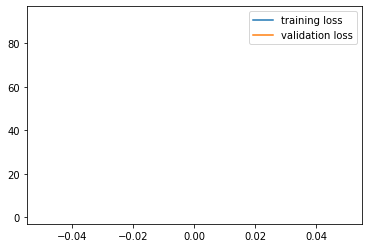

In [ ]:
#for plotting train loss with respect to val loss
x=[]
for i in range(len(loss_track[0])):
  x.append(i)
plt.plot(x, loss_track[0], label = "training loss")
plt.plot(x, loss_track[1] , label = "validation loss")
plt.legend()
plt.show()

In [ ]:
#model_save_name = 'yolo.pt'
#save_path = F"/content/gdrive/My Drive/yolo_output.pt" 
#torch.save(model.state_dict(), save_path)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

print(len(dataloaders['train']))
for i_batch, sample_batched in enumerate(dataloaders["train"]):

    input_images_batch, Orig_images_batch, label_batch, path_batch = sample_batched['input_img'], sample_batched['orig_img'], sample_batched['label'], sample_batched['path']

    print(i_batch, input_images_batch.shape, Orig_images_batch.shape, label_batch.shape)

    if i_batch == 3:
        break

966
0 torch.Size([1, 3, 416, 416]) torch.Size([1, 416, 416, 3]) torch.Size([1, 200, 5])
1 torch.Size([1, 3, 416, 416]) torch.Size([1, 416, 416, 3]) torch.Size([1, 200, 5])
2 torch.Size([1, 3, 416, 416]) torch.Size([1, 416, 416, 3]) torch.Size([1, 200, 5])
3 torch.Size([1, 3, 416, 416]) torch.Size([1, 416, 416, 3]) torch.Size([1, 200, 5])


**Testing** this is for testing

In [ ]:
 model = Darknet()
print("Loading network.....")
model.load_state_dict(torch.load('/home/nibaran/Soumyajyoti_Nilanjan/Dartnet_VOC_Weights.pt'))
print("Network successfully loaded")
#outputs

Loading network.....


FileNotFoundError: ignored

In [ ]:
import cv2
def letterbox_image(img, inp_dim):
    '''resize image with unchanged aspect ratio using padding'''
    img_w, img_h = img.shape[1], img.shape[0]
    w, h = inp_dim
    new_w = int(img_w * min(w/img_w, h/img_h))
    new_h = int(img_h * min(w/img_w, h/img_h))
    resized_image = cv2.resize(img, (new_w,new_h), interpolation = cv2.INTER_CUBIC)
    
    canvas = np.full((inp_dim[1], inp_dim[0], 3), 128)

    canvas[(h-new_h)//2:(h-new_h)//2 + new_h,(w-new_w)//2:(w-new_w)//2 + new_w,  :] = resized_image
    
    return canvas
def prep_image(img, inp_dim):

    h, w, _ = img.shape
    dim_diff = np.abs(h - w)
    # Upper (left) and lower (right) padding
    pad1, pad2 = dim_diff // 2, dim_diff - dim_diff // 2
    # Determine padding
    pad = ((pad1, pad2), (0, 0), (0, 0)) if h <= w else ((0, 0), (pad1, pad2), (0, 0))
    # Add padding
    pad_img = np.pad(img, pad, 'constant', constant_values=128)
    orig_im = pad_img
    img = cv2.resize(orig_im, (inp_dim, inp_dim))
    img_ = img[:, :, ::-1].transpose((2, 0, 1)).copy()
    img_ = torch.from_numpy(img_).float().div(255.0).unsqueeze(0)
    return img_, orig_im

In [ ]:
from google.colab.patches import cv2_imshow

Loading network.....
Network successfully loaded
image predicted in 4.867 seconds


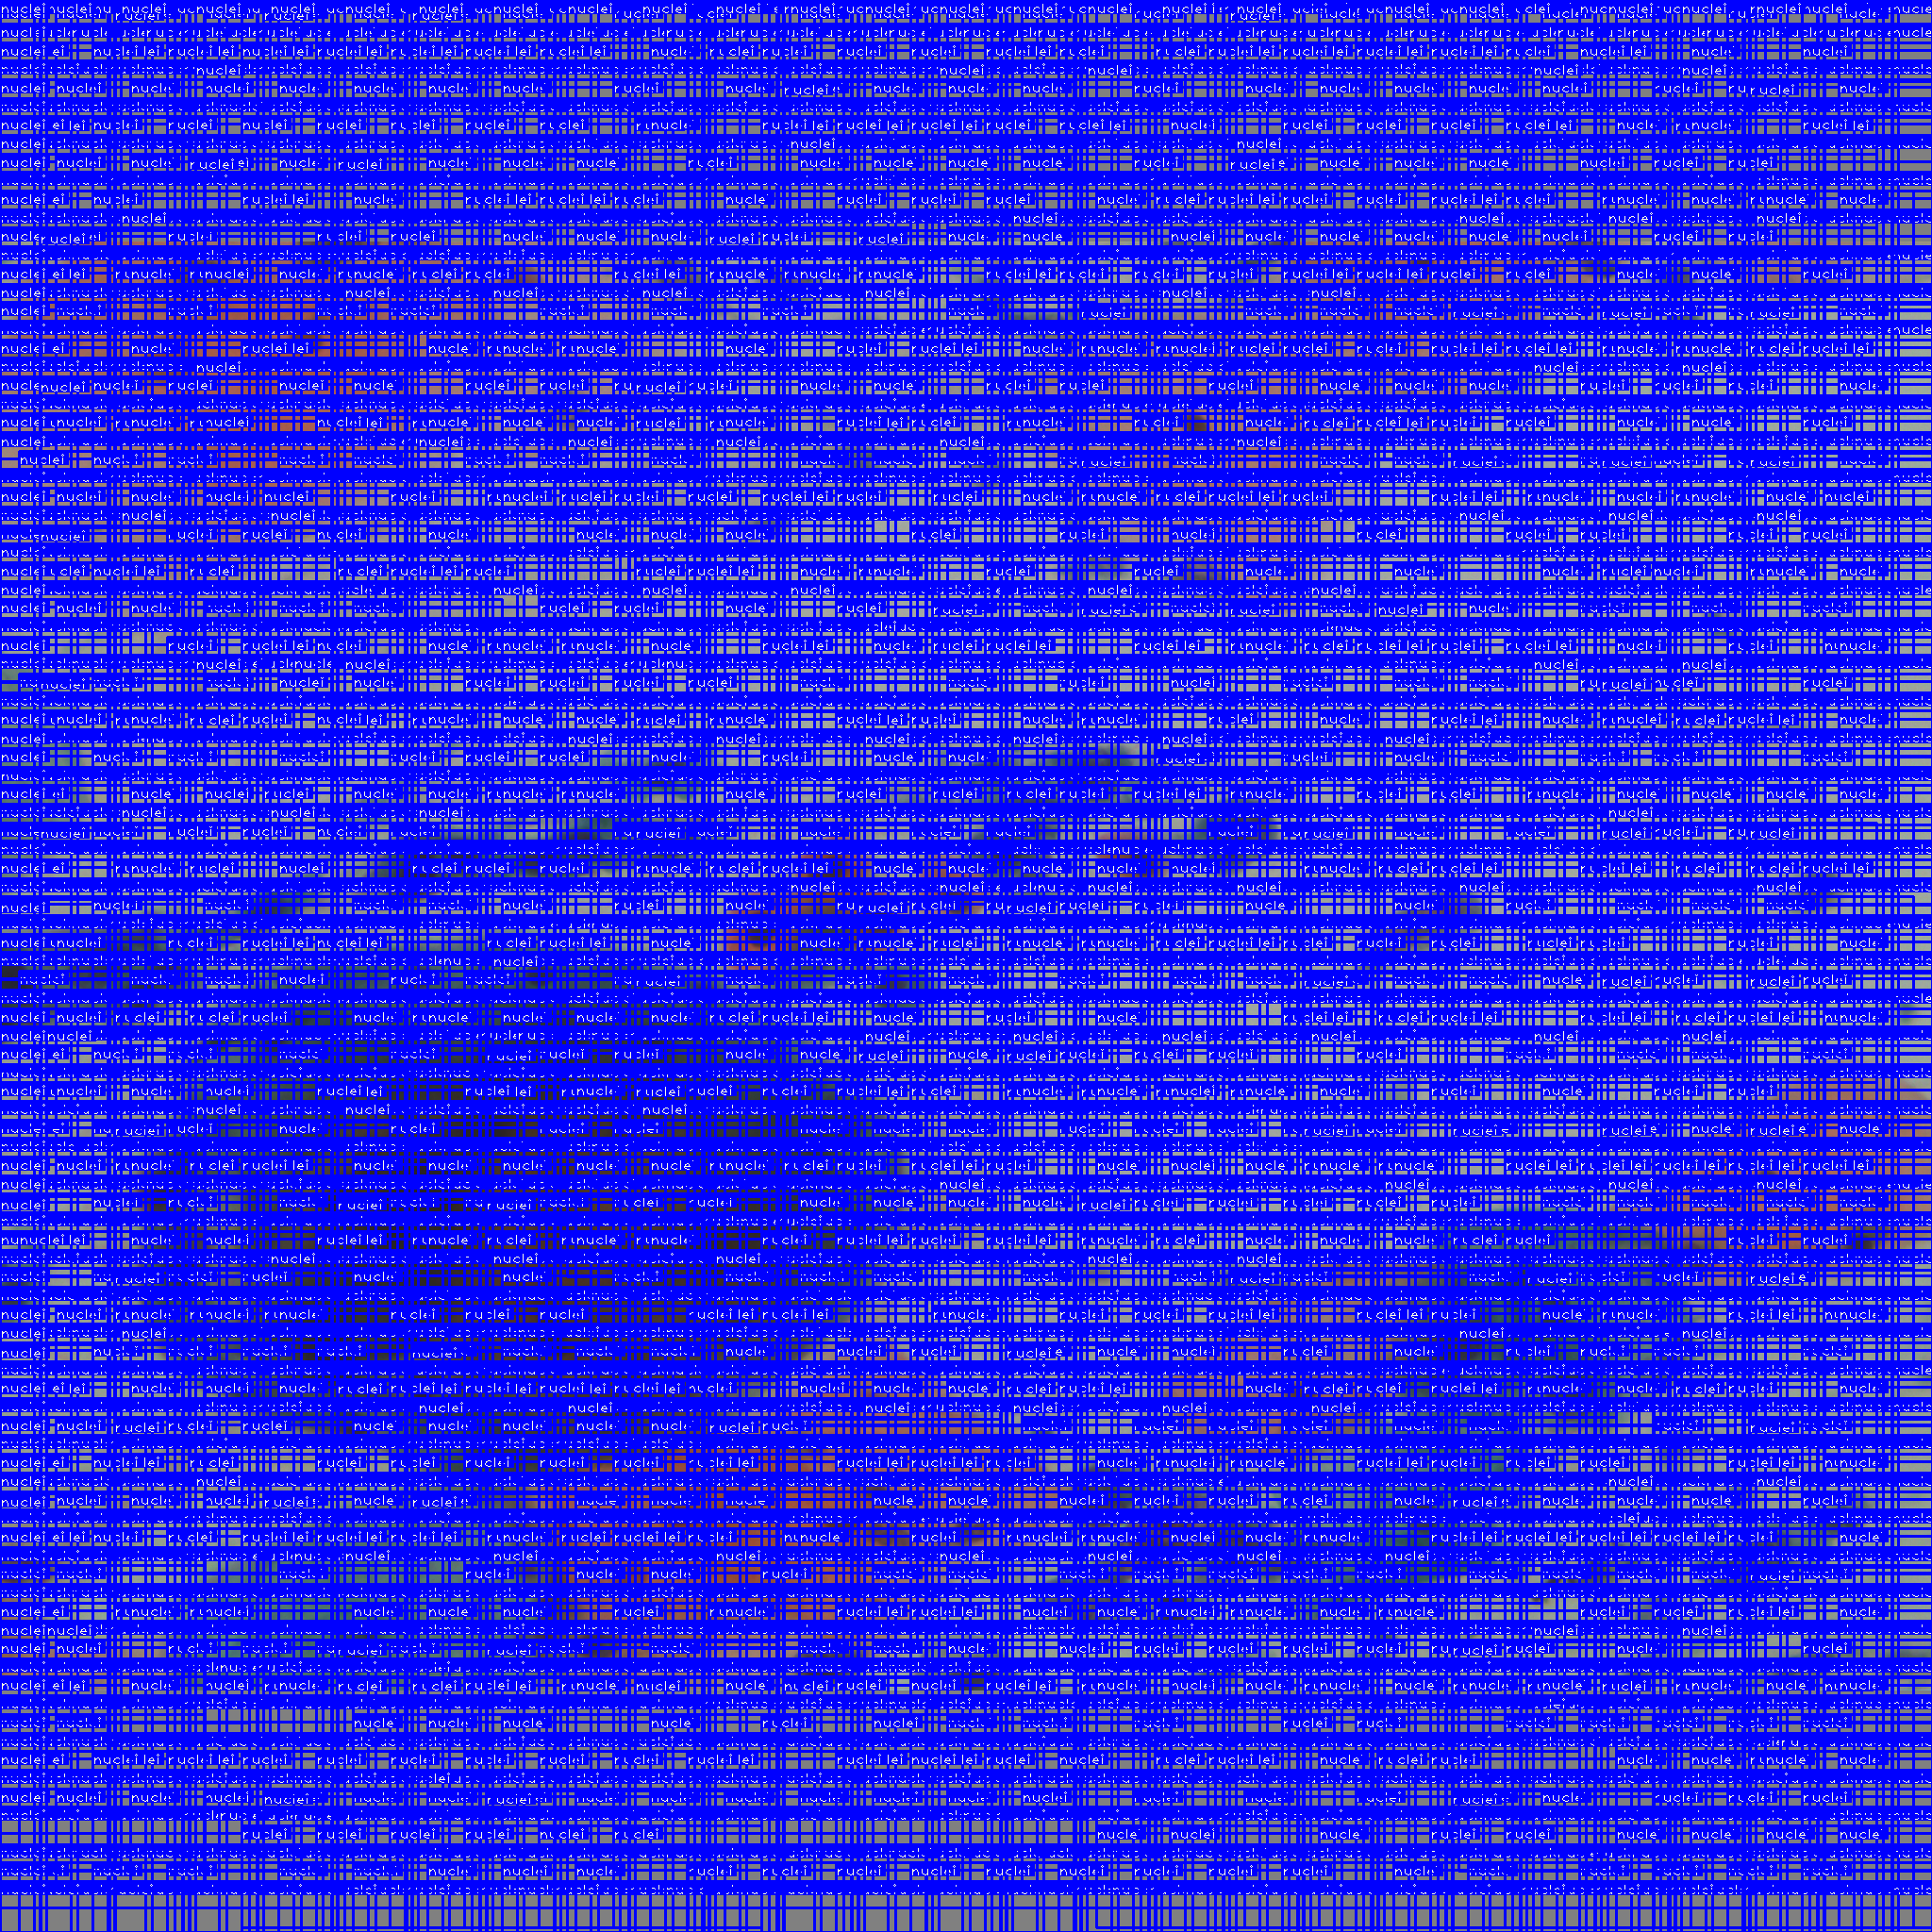

In [ ]:
from __future__ import division
import time
import torch
from torch.autograd import Variable
import cv2

import random
import argparse
import pickle as pkl
import numpy as np
import warnings
warnings.filterwarnings("ignore")

def write(x, img):

    cls = int(x[-1])
    label = "{0}".format(classes[cls])
    c1 = tuple(x[1:3].int())
    c2 = tuple(x[3:5].int())
    color =[255,0,0] #random.choice(colors)
    cv2.rectangle(img, c1, c2, color, 2)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1, 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img, c1, c2, color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225, 255, 255], 1)

    return img

def arg_parse():
    """
    Parse arguements to the detect module
    """

    parser = argparse.ArgumentParser(description='YOLO v3 Demo')
    parser.add_argument("--confidence", dest="confidence", help="Object Confidence to filter predictions", default=0.5)
    parser.add_argument("--nms_thresh", dest="nms_thresh", help="NMS Threshhold", default=0.4)
    parser.add_argument("--reso", dest='reso', help=
    "Input resolution of the network. Increase to increase accuracy. Decrease to increase speed",
                        default="416", type=str)
    return parser.parse_args()


if __name__ == '__main__':

    classes = ["nuclei"] #load_classes("data/voc.names")
    #colors = pkl.load(open("data/pallete", "rb"))

    #args = arg_parse()
    confidence = 0.5 #float(args.confidence)
    nms_thesh = 0.4 #float(args.nms_thresh)
    CUDA = torch.cuda.is_available()

    num_classes = 1

    #model = Darknet()
    print("Loading network.....")
    #model.load_state_dict(torch.load('/content/gdrive/My Drive/yolo.pt'))

    print("Network successfully loaded")
    model.image_size = "416"
    i#np_dim = int(model.image_size)

    assert inp_dim % 32 == 0
    assert inp_dim > 32

    if CUDA:
        model.cuda()

    model.eval()

    start = time.time()

    frame = cv2.imread('/content/gdrive/MyDrive/data/sample/001.bmp')      #Image path to the test image
    
    img, orig_im = prep_image(frame, inp_dim)

    if CUDA:
        img = img.cuda()

    output, _ , _, _= model(Variable(img), CUDA)
    # batch_size x number of boxes x attrs (85)  attrs have been transposed to input image
    output = write_results(output, confidence, num_classes, nms_conf=nms_thesh)
    # D x 8, D is the true detection  8: image index in batch, 4 corner coordinates, object score,highest class score, class index

    if isinstance(output, int) == False:
        output[:, 1:5] = torch.clamp(output[:, 1:5], 0.0, float(inp_dim)) / inp_dim
        output[:, [1, 3]] *= orig_im.shape[1]
        output[:, [2, 4]] *= orig_im.shape[0]

        list(map(lambda x: write(x, orig_im), output))

    print("image predicted in {:2.3f} seconds".format(time.time()- start))
    
    cv2_imshow( orig_im)
    

Testing final